In [3]:
import os,sys,inspect
currentdir = "D:/BAMT/plan/big_cluster"
parentdir = os.path.dirname(currentdir)
parentparentdir = os.path.dirname(parentdir)
sys.path.insert(0,parentparentdir)

In [4]:
import pandas as pd
import random
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning
from preprocess.discretization import get_nodes_type, discretization, code_categories, get_nodes_sign

from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from copy import copy
from visualization.visualization import draw_BN, draw_comparative_hist, get_probability
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from core.core_utils import project_root
from external.pyBN.utils.independence_tests import mutual_information, entropy, mi_from_en
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score
import seaborn as sns
import sklearn.metrics as skm
import scipy.stats as ss
from scipy.spatial.distance import cdist
from external.libpgm.sampleaggregator import SampleAggregator
from sklearn.metrics import accuracy_score, mean_squared_error
import operator
from typing import Tuple
import json
from bayesian.sampling import generate_synthetics
from graph.precision_recall import child_dict
from visualization.visualization import get_probability, grouped_barplot
from bayesian.calculate_accuracy import parall_accuracy
from scipy.spatial.distance import cdist
import gower

In [5]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [6]:
data = pd.read_csv(f'{project_root()}/data/vk_data.csv')
data.reset_index(drop=True, inplace=True)
print(set(data.dtypes))
print(data.columns[data.dtypes == 'int64'])
print(data.columns[data.dtypes == 'float64'])
print(data.columns[data.dtypes == 'object'])

{dtype('int64'), dtype('O'), dtype('float64')}
Index(['sex', 'city_id', 'has_high_education', 'relation', 'num_of_relatives',
       'followers_count', 'status', 'mobile_phone', 'twitter', 'facebook',
       'instagram', 'about', 'activities', 'books', 'interests', 'movies',
       'music', 'quotes', 'personal_alcohol', 'personal_life_main',
       'personal_people_main', 'personal_political', 'cash_usage', 'top1',
       'top2', 'top3', 'is_gamer', 'is_parent', 'is_driver', 'has_pets'],
      dtype='object')
Index(['age', 'HLength', 'max_tr', 'min_tr', 'mean_tr', 'median_tr', '90_perc',
       'sum_am', 'tr_per_month', 'cash_sum', 'top1_mean', 'top2_mean',
       'top3_mean', 'game_sum', 'parent_sum', 'driver_sum', 'pets_sum',
       'dress, fashion, color, style', 'massage, meditation, yoga',
       'game, team, competition, sport', 'color, flowers, interior, design',
       'iphone, apple, technology, equipment, smartphone',
       'client, project, internet, business, company',
   

In [7]:
print(data.columns)

Index(['sex', 'age', 'city_id', 'has_high_education', 'relation',
       'num_of_relatives', 'followers_count', 'status', 'mobile_phone',
       'twitter', 'facebook', 'instagram', 'about', 'about_topic',
       'activities', 'activities_topic', 'books', 'interests',
       'interests_topic', 'movies', 'music', 'quotes', 'personal_alcohol',
       'personal_life_main', 'personal_people_main', 'personal_political',
       'HLength', 'max_tr', 'min_tr', 'mean_tr', 'median_tr', '90_perc',
       'sum_am', 'tr_per_month', 'cash_sum', 'cash_usage', 'top1', 'top1_mean',
       'top2', 'top2_mean', 'top3', 'top3_mean', 'game_sum', 'is_gamer',
       'parent_sum', 'is_parent', 'driver_sum', 'is_driver', 'pets_sum',
       'has_pets', 'dress, fashion, color, style', 'massage, meditation, yoga',
       'game, team, competition, sport', 'color, flowers, interior, design',
       'iphone, apple, technology, equipment, smartphone',
       'client, project, internet, business, company',
       'war,

In [8]:
boarders = [1, 50, 100]
interesting = {}
for var in list(data.columns):
    count = len(set(data[var].values))
    if (count> boarders[1]):
        if data[var].dtype == 'O':
            print(var)
        interesting[var] = count
sorted_tuples = sorted(interesting.items(), key=lambda item: item[1])
sorted_dict = {k: v for k, v in sorted_tuples}
sorted_dict


{'age': 69,
 'top1': 110,
 'num_of_relatives': 132,
 'city_id': 136,
 'top2': 159,
 'about': 175,
 'top3': 176,
 'HLength': 641,
 'followers_count': 1102,
 'driver_sum': 1381,
 'game_sum': 2582,
 'min_tr': 4817,
 'pets_sum': 5092,
 'max_tr': 7539,
 'parent_sum': 10124,
 'cash_sum': 14017,
 'median_tr': 14243,
 '90_perc': 19981,
 'tr_per_month': 21293,
 'top3_mean': 25597,
 'top2_mean': 26860,
 'top1_mean': 28219,
 'sum_am': 29136,
 'mean_tr': 29221,
 'handmade, materials, products': 29721,
 'sale, clothes, size, price, sewing': 29835,
 'ingredients, cooking, dishes, salt, spices': 29845,
 'dress, fashion, color, style': 29871,
 'work, schedule, earnings, money': 29881,
 'skin, face, care, cosmitology': 29883,
 'book, reading, language, word, literature': 29885,
 'treatment, doctors, tests, clinic, health': 29887,
 'car, cars, sale, tires': 29887,
 'iphone, apple, technology, equipment, smartphone': 29890,
 'client, project, internet, business, company': 29893,
 'school, education, ques

In [9]:
boarder = 50
interesting = {}
for var in list(data.columns):
    count = len(set(data[var].values))
    if (count> boarder):
        data[var] = data[var].apply(lambda x: float(x))
    else:
        data[var] = data[var].apply(lambda x: str(x))
data['city_id'] = data['city_id'].apply(lambda x: int(x)).apply(lambda x: str(x))


In [10]:
col_inter = ['sex', 'age', 'city_id', 'has_high_education', 'relation',
       'num_of_relatives', 'followers_count', 'status', 'mobile_phone',
       'twitter', 'facebook', 'instagram', 'about', 'about_topic',
       'activities', 'activities_topic', 'books', 'interests',
       'interests_topic', 'movies', 'music', 'quotes', 'personal_alcohol',
       'personal_life_main', 'personal_people_main', 'personal_political',
       'HLength', 'max_tr', 'min_tr', 'mean_tr', 'median_tr', '90_perc',
       'sum_am', 'tr_per_month', 'cash_sum', 'cash_usage', 'top1', 'top1_mean',
       'top2', 'top2_mean', 'top3', 'top3_mean', 'game_sum', 'is_gamer',
       'parent_sum', 'is_parent', 'driver_sum', 'is_driver', 'pets_sum',
       'has_pets']

In [11]:
len(col_inter)

50

In [12]:
data=data[col_inter]

In [13]:
data = data.sample(n=1500, random_state=1)

In [14]:
data_types = get_nodes_type(data)

In [15]:
"""small_columns = []
for var in data_types:
    if data_types[var] != 'disc':
        if data[var].max()-data[var].min() < 1.0:
            small_columns.append(var)
data.drop(small_columns, axis=1, inplace=True)"""

"small_columns = []\nfor var in data_types:\n    if data_types[var] != 'disc':\n        if data[var].max()-data[var].min() < 1.0:\n            small_columns.append(var)\ndata.drop(small_columns, axis=1, inplace=True)"

In [16]:
data_types = get_nodes_type(data)

In [17]:
colums_for_code = []
columns_for_disc = []
for c in data.columns:
    if data_types[c] == 'disc':
        colums_for_code.append(c)
    else:
        columns_for_disc.append(c)
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

In [18]:
data_types

{'sex': 'disc',
 'age': 'cont',
 'city_id': 'disc',
 'has_high_education': 'disc',
 'relation': 'disc',
 'num_of_relatives': 'cont',
 'followers_count': 'cont',
 'status': 'disc',
 'mobile_phone': 'disc',
 'twitter': 'disc',
 'facebook': 'disc',
 'instagram': 'disc',
 'about': 'cont',
 'about_topic': 'disc',
 'activities': 'disc',
 'activities_topic': 'disc',
 'books': 'disc',
 'interests': 'disc',
 'interests_topic': 'disc',
 'movies': 'disc',
 'music': 'disc',
 'quotes': 'disc',
 'personal_alcohol': 'disc',
 'personal_life_main': 'disc',
 'personal_people_main': 'disc',
 'personal_political': 'disc',
 'HLength': 'cont',
 'max_tr': 'cont',
 'min_tr': 'cont',
 'mean_tr': 'cont',
 'median_tr': 'cont',
 '90_perc': 'cont',
 'sum_am': 'cont',
 'tr_per_month': 'cont',
 'cash_sum': 'cont',
 'cash_usage': 'disc',
 'top1': 'cont',
 'top1_mean': 'cont',
 'top2': 'cont',
 'top2_mean': 'cont',
 'top3': 'cont',
 'top3_mean': 'cont',
 'game_sum': 'cont',
 'is_gamer': 'disc',
 'parent_sum': 'cont',


In [19]:
data_coded, label_coder = code_categories(data, 'label', colums_for_code)
data_discrete, coder = discretization(data_coded, 'equal_frequency', columns_for_disc)

d:\BAMT\BAMT\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
d:\BAMT\BAMT\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
d:\BAMT\BAMT\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 13 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
d:\BAMT\BAMT\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 19 are removed. Consider decreasing the number of bins.
  warn

In [20]:
data_coded.head()

,sex,age,city_id,has_high_education,relation,num_of_relatives,followers_count,status,mobile_phone,twitter,...,top3,top3_mean,game_sum,is_gamer,parent_sum,is_parent,driver_sum,is_driver,pets_sum,has_pets
0,1,28.0,5,1,0,2.0,51.0,4,0,0,...,5814.0,174.000000,0.0,0,0.0,0,0.0,0,0.0,0
1,1,49.0,5,0,0,2.0,0.0,0,0,0,...,5211.0,8145.000000,0.0,0,0.0,0,0.0,0,0.0,0
2,0,25.0,5,0,0,2.0,75.0,0,0,0,...,5999.0,443.750000,0.0,0,0.0,0,0.0,0,0.0,0
3,1,40.0,5,0,0,2.0,55.0,0,0,0,...,6051.0,104.703333,0.0,0,0.0,0,0.0,0,0.0,0
4,1,38.0,5,0,0,2.0,1.0,0,0,0,...,5499.0,473.000000,0.0,0,0.0,0,0.0,0,0.0,0


In [21]:
#Error of pyBN
print('One column')
print(entropy(data_discrete['sex'].values))
print('Two columns. More 1.0')
print(entropy(data_discrete[['sex']].values))
print('It\'s entropy. More 1.0')
print(mutual_information(data_discrete[['sex']].values))
print('It\'s entropy too.')
print(mi_from_en(data_discrete[['sex','sex']].values))

One column
-0.0
Two columns. More 1.0
-0.0
It's entropy. More 1.0
0.6921
It's entropy too.
-0.0


In [22]:
data_discrete['sex'].values

array([1, 1, 0, ..., 1, 0, 1])

In [23]:
#Scipy
print('One column. More 1.0')
print(ss.entropy(data_discrete['sex'].values))
print('Two columns. More 1.0')
print(ss.entropy(data_discrete[['sex']].values))
print('It\'s entropy too')
print(mutual_info_score(data_discrete['sex'].values, data_discrete['sex'].values))

One column. More 1.0
6.664409020350407
Two columns. More 1.0
[6.66440902]
It's entropy too
0.6921192727579402


In [24]:
print(mutual_info_score(data_discrete['sex'].values, data_discrete['sex'].values))

0.6921192727579402


In [25]:
print(mutual_info_score(data_discrete['sex'].values, data_discrete['has_high_education'].values))

0.001326040297369352


In [26]:
def su_dist(x, y): 
    #print(x)
    #print(y)
    #z = np.concatenate((np.array(x).reshape(-1, 1), np.array(y).reshape(-1, 1)), axis=1)
    #z = np.concatenate((x, y), axis=1)
    """if (entropy(x) + entropy(y)) == 0.0:
        print(mi_from_en(z))
        return 0.0
    else:
        return - 2 * mi_from_en(z) / (entropy(x) + entropy(y))"""
    return 1.0 - normalized_mutual_info_score(x, y)

In [27]:
su_dist(data_discrete['age'].values, data_discrete['age'].values)

0.0

In [28]:
su_dist(data_discrete['age'].values, data_discrete['sex'].values)

0.9977933829029682

In [29]:
column = list(data.columns)
D = [[0.0 for i in column] for j in column]
for i, var1 in enumerate(column):
    for j, var2 in enumerate(column):
        D[i][j] = su_dist(data_discrete[var1].values, data_discrete[var2].values)
#D = np.where(np.isnan(D), 0.0, D)    


In [30]:
#model = AgglomerativeClustering(n_clusters=30, affinity='precomputed', linkage='average')
model = AgglomerativeClustering(distance_threshold=0.75, n_clusters=None, affinity='precomputed', linkage='single')
model = model.fit_predict(D)
res_dict = {}
for i, val in enumerate(model):
    if val in res_dict:
        res_dict[val].append(column[i])
    else:
        res_dict[val] = [column[i]]
for key, val in res_dict.items():
    if len(val) > 1:
        print(val)

['num_of_relatives', 'about', 'game_sum', 'driver_sum']
['about_topic', 'activities', 'activities_topic', 'books', 'interests', 'interests_topic', 'movies', 'music', 'quotes']
['personal_alcohol', 'personal_life_main', 'personal_people_main']
['max_tr', 'sum_am', 'cash_sum', 'cash_usage']
['mean_tr', '90_perc']
['median_tr', 'top1', 'top1_mean']
['parent_sum', 'is_parent']


In [31]:
"""linkage_matrix = linkage(D, "single")
dendrogram(linkage_matrix, labels=column)
plt.title("test")
plt.show()"""

'linkage_matrix = linkage(D, "single")\ndendrogram(linkage_matrix, labels=column)\nplt.title("test")\nplt.show()'

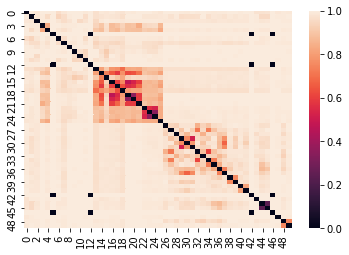

In [32]:
ax = sns.heatmap(D)

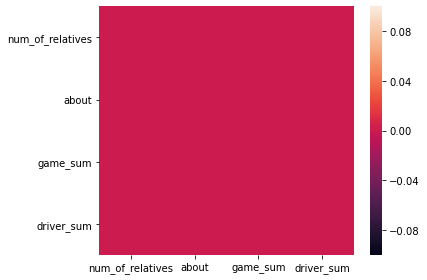

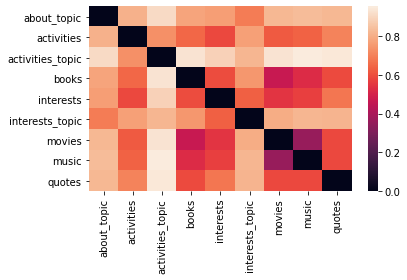

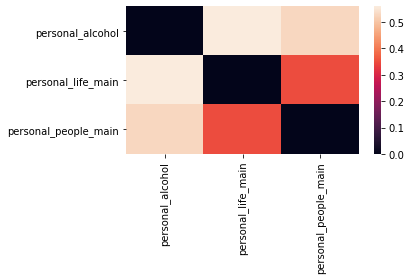

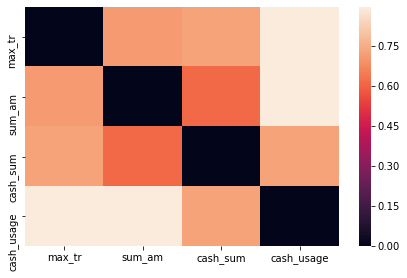

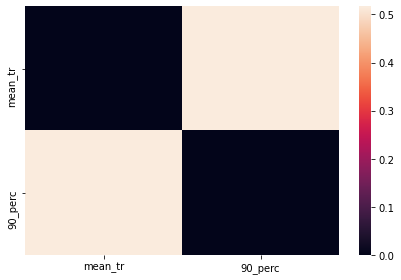

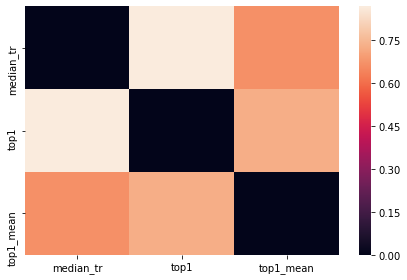

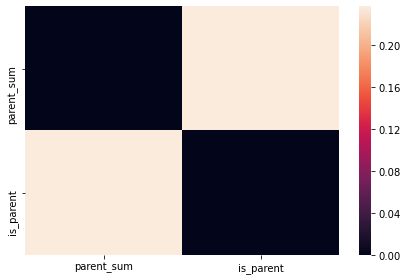

In [33]:
ind_dict = {}
for i, val in enumerate(model):
    if val in ind_dict:
        ind_dict[val].append(i)
    else:
        ind_dict[val] = [i]
count = 0
for key, val in ind_dict.items():
    if len(val) > 1:
        count += 1

g = [None for _ in range(count)]
ind = 0
for key, val in ind_dict.items():
    if len(val) > 1:
        loc_D = [[D[i][j] for j in val] for i in val]
        fig, ax = plt.subplots()
        ax = sns.heatmap(loc_D, xticklabels=[column[i] for i in val], yticklabels=[column[i] for i in val])
        plt.tight_layout()
        plt.savefig(str([column[i] for i in val]))
        #fig.clear()
        ind += 1

In [34]:
def zip_code(data_discrete: pd.DataFrame, cluster_columns: list, alpha: float = 0.95, low_limit: int = 30):
    group = copy(data_discrete).groupby(cluster_columns)
    comb = group.size().reset_index().rename(columns={0:'count'})
    comb['count'] = comb['count'] / len(data_discrete)
    comb.sort_values(by=['count'], inplace=True, ascending=False)
    sum = 0.0
    ind = 0
    while (sum < alpha) & (comb.iloc[ind]['count'] >= low_limit / len(data_discrete)):
        sum += comb.iloc[ind]['count']
        ind += 1
        if ind == len(comb):
            break

    x, _ = code_categories(comb, 'onehot', cluster_columns)
    x = x.values
    if ind < len(comb):
        dists = cdist(x[ind:, :], x[:ind, :], metric='hamming')
        neighbors_map = [list(np.where(row == row.min())[0]) for row in dists]
        neighbors_map = [args[-1] for args in neighbors_map]
        better = [i if (i < ind) else neighbors_map[i - ind] for i in range(len(comb))]
    else:
        better = [i for i in range(len(comb))]

    code_col = [None for _ in range(len(data_discrete))]
    for i in range(len(comb)):
        merged_values = tuple(comb[cluster_columns].iloc[i])
        for j in group.indices[merged_values]:
            code_col[j] = better[i]

    return code_col

In [35]:

def zip_code_hamm(data_discrete: pd.DataFrame, cluster_columns: list, alpha: float = 0.95):
    group = copy(data_discrete).groupby(cluster_columns, as_index=True) 
    x = list(group.groups.keys())
    if len(x) > 1:
        dists = cdist(x, x, metric='hamming')
        model = AgglomerativeClustering(distance_threshold=alpha, n_clusters=None, affinity='precomputed', linkage='single')
        model = model.fit_predict(dists)
    else:
        model = [0]
    
    code_col = [None for _ in range(len(data_discrete))]
    for i in range(len(data_discrete)):
        merged_values = tuple(data_discrete[cluster_columns].iloc[i])
        code_col[i] = model[x.index(merged_values)]
    return code_col

In [77]:
def zip_code_gower(data: pd.DataFrame, disc_col: list, cluster_columns: list, alpha: float = 0.95):
    x = copy(data[cluster_columns]).values
    if len(x) > 1:
        dists = gower.gower_matrix(x, cat_features=disc_col)
        model = AgglomerativeClustering(distance_threshold=alpha, n_clusters=None, affinity='precomputed', linkage='single')
        model = model.fit_predict(dists)
    else:
        model = [0]

    return list(model)


In [75]:
df_test = pd.DataFrame({'a': [0, 1, 1, 0], 'b': [0, 1, 1, 1], 'c': [1, 1, 0, 1]})
zip_code_hamm(df_test, ['a','b'], alpha = 0.5)

[2, 0, 0, 1]

In [84]:
df_test = pd.DataFrame({'a': [0.0, 0.0, 1.0, 0.0], 'b': [0.0, 1.0, 1.0, 1.0], 'c': [1, 1, 0, 1]})
zip_code_gower(df_test, [False, False], ['a','b'], alpha = 0.5)

[2, 0, 1, 0]

In [33]:
df2 = pd.DataFrame()
for key, val in res_dict.items():
    if len(val) > 1:
        code_col = zip_code_hamm(data_discrete, val)
        df2[tuple(val)] = code_col
    else:
        df2[tuple(val)] = data_discrete[val[0]]

In [34]:
tuple_columns = df2.columns
rename_dict = {tuple_columns[i]: i  for i in range(len(tuple_columns))}
df2.rename(rename_dict, axis = 1, inplace=True)
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1,0,5,1,0,0,2,4,0,0,...,0,0,0,3,0,0,0,0,0,0
1,1,4,5,0,0,0,0,0,0,0,...,1,1,2,0,4,0,0,0,0,0
2,0,0,5,0,0,0,3,0,0,0,...,2,2,1,3,1,0,0,0,0,0
3,1,3,5,0,0,0,2,0,0,0,...,0,1,0,4,0,0,0,0,0,0
4,1,2,5,0,0,0,0,0,0,0,...,0,3,0,1,1,0,0,0,0,0


In [35]:
bn_without = structure_learning(data_discrete, 'HC', get_nodes_type(data), 'BIC', cont_disc = False)

In [67]:
draw_BN(bn_without, {var: 'disc' for var in bn_without['V']}, f'rename_vk_' + 'full')

In [36]:
#draw_BN(bn_without, {var: 'disc' for var in bn_without['V']}, 'without_full_net')

In [37]:
node_type = {}
for key, val in rename_dict.items():
    if len(key) > 1:
        node_type[val] = 'dict'
    else:
        node_type[val] = data_types[key[0]]
    

In [38]:
#node_type

In [39]:
bn = structure_learning(df2, 'HC', node_type, 'BIC', cont_disc = False)

In [40]:
rerename_dict = {val: str(key) for key, val in rename_dict.items()}
bn_rename = copy(bn)
bn_rename['V'] = [rerename_dict[var] for var in bn_rename['V']]
bn_rename['E'] = [[rerename_dict[var1], rerename_dict[var2]]  for var1, var2 in bn_rename['E']]

In [41]:
#draw_BN(bn_rename, {rerename_dict[key]: val for key, val in node_type.items()}, 'coded_vars')

In [42]:
bn_dict = dict()
for key, val in res_dict.items():
    if len(val) > 1:
        bn_loc = structure_learning(data_discrete[val], 'HC', {key_t: val_t for key_t, val_t in data_types.items() if key_t in val}, 'BIC', cont_disc = True)
        bn_dict[str(tuple(val))] = bn_loc
#bn_dict

In [63]:
for key, val in res_dict.items():
    if len(val) > 1:
        bn_loc = copy(bn_dict[str(tuple(val))])
        bn_loc['V'] = [rerename_dict_new[var] for var in bn_loc['V']]
        bn_loc['E'] = [[rerename_dict_new[var1], rerename_dict_new[var2]]  for var1, var2 in bn_loc['E']]
        draw_BN(bn_loc, {var: 'disc' for var in bn_loc['V']}, f'rename_vk_' + str(bn_loc['V']))

In [43]:
bn_full = copy(bn_rename)
for key, bn_loc in bn_dict.items():
    bn_full['V'].extend(bn_loc['V'])
    bn_full['V'].remove(key)
    bn_full['V'].extend([key+"_in", key+'_out'])
    for i in range(len(bn_full['E'])):
        e0, e1 = bn_full['E'][i]
        if e0 == key:
            bn_full['E'][i] = [key+'_out', e1]
        if e1 == key:
            bn_full['E'][i] = [e0, key+'_in']
    bn_full['E'].extend(bn_loc['E'])
    bn_full['E'].extend([[key+'_in', var] for var in bn_loc['V']])
    bn_full['E'].extend([[var, key+'_out'] for var in bn_loc['V']])

In [44]:
#print(bn_full['V'])
rerename_dict_new = dict() 
for var in bn_full['V']:
    if (',)' in var):
        rerename_dict_new[var] = eval(var)[0]
    else:
        rerename_dict_new[var] = var
bn_full_rename = copy(bn_full)
bn_full_rename['V'] = [rerename_dict_new[var] for var in bn_full_rename['V']]
bn_full_rename['E'] = [[rerename_dict_new[var1], rerename_dict_new[var2]]  for var1, var2 in bn_full_rename['E']]
print(bn_full_rename['V'])

['sex', 'age', 'city_id', 'has_high_education', 'relation', 'followers_count', 'status', 'mobile_phone', 'twitter', 'facebook', 'instagram', 'personal_political', 'HLength', 'min_tr', 'tr_per_month', 'top2', 'top2_mean', 'top3', 'top3_mean', 'is_gamer', 'is_driver', 'pets_sum', 'has_pets', 'num_of_relatives', 'about', 'game_sum', 'driver_sum', "('num_of_relatives', 'about', 'game_sum', 'driver_sum')_in", "('num_of_relatives', 'about', 'game_sum', 'driver_sum')_out", 'about_topic', 'activities', 'activities_topic', 'books', 'interests', 'interests_topic', 'movies', 'music', 'quotes', "('about_topic', 'activities', 'activities_topic', 'books', 'interests', 'interests_topic', 'movies', 'music', 'quotes')_in", "('about_topic', 'activities', 'activities_topic', 'books', 'interests', 'interests_topic', 'movies', 'music', 'quotes')_out", 'personal_alcohol', 'personal_life_main', 'personal_people_main', "('personal_alcohol', 'personal_life_main', 'personal_people_main')_in", "('personal_alcoho

In [61]:
draw_BN(bn_full_rename, {var: 'disc' for var in bn_full_rename['V']}, 'rename_vk')

In [45]:
rename_dict = {str(key): val for key, val in rename_dict.items()}

In [46]:
#data_add = copy(data)
data_add = copy(data_discrete)
for key in bn_full_rename['V']:
    if ')_in' in key:
        data_add[key] = df2[rename_dict[key[:-3]]]
    if ')_out' in key:
        data_add[key] = df2[rename_dict[key[:-4]]]
        

In [47]:
print(len(data.columns))

50


In [48]:
rename_again = {var: str(i) for i, var in enumerate(data_add.columns)}
#rename_again

In [49]:
rename_again_inv = {i: var for var, i in rename_again.items()}

In [50]:
data_add.rename(rename_again, axis=1, inplace=True)
data_add.head()
        

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,1,0,5,1,0,0,2,4,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,4,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,5,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,5,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
bn_full_rename_again = copy(bn_full_rename)
bn_full_rename_again['V'] = [rename_again[var] for var in bn_full_rename['V']]
bn_full_rename_again['E'] = [[rename_again[var1], rename_again[var2]]  for var1, var2 in bn_full_rename['E']]
#bn_full_rename_again
        

In [52]:
nodes_loc_net = {}
full_net = copy(bn_full_rename_again)
for var in full_net['V']:
    if ')_' not in rename_again_inv[var]:
        nodes_loc_net[var] = {'V': [var], 'E': []}
        nodes_loc = set([var])
        for e0, e1 in full_net['E']:
            if e1 == var:
                nodes_loc_net[var]['E'].append([e0, e1])
                nodes_loc.add(e0)
                if (')_out' in rename_again_inv[e0]) or (')_in' in rename_again_inv[e0]):
                    for e2, e3 in full_net['E']:
                        if (e3 == e0) and (e2 != var):
                            nodes_loc_net[var]['E'].append([e2, e3])
                            nodes_loc.add(e2)
        
        nodes_loc_net[var]['V'] = list(nodes_loc)
#print(nodes_loc_net)




In [53]:
for key, val in nodes_loc_net.items():  
    draw_BN(val, {var: 'disc' for var in val['V']}, f'local_net_for_{rename_again_inv[key]}')

In [54]:
save_structure(bn_full_rename, 'hamm_coded_vars_full_net')

In [55]:
#draw_BN(bn_full_rename, {var: 'disc' for var in bn_full_rename['V']}, 'coded_full_net')

In [56]:
example = dict()
example['V'] = ["('parent_sum', 'is_parent')_in", "('parent_sum', 'is_parent')_out", 'parent_sum', 'is_parent']
example['E'] = [["('parent_sum', 'is_parent')_in", 'is_parent'], ["('parent_sum', 'is_parent')_in", 'parent_sum'], ['is_parent', 'parent_sum'],
 ['parent_sum', "('parent_sum', 'is_parent')_out"], ['is_parent', "('parent_sum', 'is_parent')_out"] ]
#draw_BN(example, {var: 'disc' for var in example['V']}, 'example_block')

In [57]:
nodes_type_add = get_nodes_type(data_add)

In [58]:
ind = 1 
nodes_loc_param = {}
for key, val in nodes_loc_net.items():
    if any([')_' in rename_again_inv[var] for var in val['V']]):
        try:
            params = parameter_learning(data_add[val['V']], {key1: val1 for key1, val1 in nodes_type_add.items() if key1 in val['V']}, val, 'simple', 'kNN')
            nodes_loc_param[key] = params
            save_params(params, f'hamm_coded_vars_full_param_{rename_again_inv[key]}')
            print('success')
        except:
            print(ind)
            ind += 1


success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success


In [59]:
nodes_loc_net[rename_again['is_parent']]['E']

[['62', '45'], ['25', '62'], ['2', '62'], ['7', '62']]

In [60]:
key = 'has_pets'
rename_key = rename_again[key]
save_structure(nodes_loc_net[rename_key], f'hamm_coded_vars_full_net_{key}')
skelet = read_structure(f'hamm_coded_vars_full_net_{key}')
params = read_params(f'hamm_coded_vars_full_param_{key}')
bn_h = HyBayesianNetwork(skelet, params)
sample1 = generate_synthetics(bn_h, get_nodes_sign(data_add[nodes_loc_net[rename_key]['V']]), 'simple', 200)

FileNotFoundError: [Errno 2] No such file or directory: 'd:\\BAMT/models/parameter_bn/hamm_coded_vars_full_param_has_pets.txt'

In [ ]:
sample1[[rename_key]].head()

,49
0,0
1,1
2,0
3,1
4,1


In [ ]:
data_add[[rename_key]].head()

,49
0,0
1,0
2,0
3,0
4,0


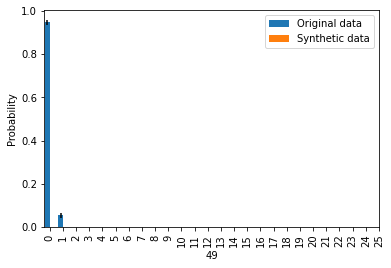

In [ ]:
draw_comparative_hist(rename_key, data_add[[rename_key]], sample1[[rename_key]], {rename_key: 'disc'})

In [ ]:
bn_without_rename_again = copy(bn_without)
bn_without_rename_again['V'] = [rename_again[var] for var in bn_without['V']]
bn_without_rename_again['E'] = [[rename_again[var1], rename_again[var2]]  for var1, var2 in bn_without['E']]

In [ ]:
nodes_without_loc_net = {}
full_net = copy(bn_without_rename_again)
for var in full_net['V']:
    if ')_' not in rename_again_inv[var]:
        nodes_without_loc_net[var] = {'V': [var], 'E': []}
        nodes_loc = set([var])
        for e0, e1 in full_net['E']:
            if e1 == var:
                nodes_without_loc_net[var]['E'].append([e0, e1])
                nodes_loc.add(e0)
                if (')_out' in rename_again_inv[e0]) or (')_in' in rename_again_inv[e0]):
                    for e2, e3 in full_net['E']:
                        if (e3 == e0) and (e2 != var):
                            nodes_without_loc_net[var]['E'].append([e2, e3])
                            nodes_loc.add(e2)
        
        nodes_without_loc_net[var]['V'] = list(nodes_loc)

In [ ]:
for key, val in nodes_without_loc_net.items():  
    draw_BN(val, {var: 'disc' for var in val['V']}, f'local_without_net_for_{rename_again_inv[key]}')

In [ ]:
save_structure(bn_without, 'hamm_without_full_net')

In [ ]:
#data_without = copy(data)
data_without = copy(data_coded)
data_without.rename(rename_again, axis=1, inplace=True)
data_without.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1,28.0,5,1,0,2.0,51.0,4,0,0,...,5814.0,174.000000,0.0,0,0.0,0,0.0,0,0.0,0
1,1,49.0,5,0,0,2.0,0.0,0,0,0,...,5211.0,8145.000000,0.0,0,0.0,0,0.0,0,0.0,0
2,0,25.0,5,0,0,2.0,75.0,0,0,0,...,5999.0,443.750000,0.0,0,0.0,0,0.0,0,0.0,0
3,1,40.0,5,0,0,2.0,55.0,0,0,0,...,6051.0,104.703333,0.0,0,0.0,0,0.0,0,0.0,0
4,1,38.0,5,0,0,2.0,1.0,0,0,0,...,5499.0,473.000000,0.0,0,0.0,0,0.0,0,0.0,0


In [ ]:
nodes_type_without = get_nodes_type(data_without)

In [ ]:
ind = 1 
nodes_without_loc_param = {}
for key, val in nodes_without_loc_net.items():
    if key in nodes_loc_param:
        try:
            params = parameter_learning(data_without[val['V']], {key1: val1 for key1, val1 in nodes_type_without.items() if key1 in val['V']}, val, 'simple', 'kNN')
            nodes_without_loc_param[key] = params
            save_params(params, f'hamm_without_param_{rename_again_inv[key]}')
            #print('success')
        except:
            print(ind)
            ind += 1

In [ ]:
rename_key

'49'

In [ ]:
key = 'is_parent'
rename_key = rename_again[key]
save_structure(nodes_without_loc_net[rename_key], f'hamm_without_net_{key}')
skelet = read_structure(f'hamm_without_net_{key}')
params = read_params(f'hamm_without_param_{key}')
bn_h_without = HyBayesianNetwork(skelet, params)
sample1 = generate_synthetics(bn_h_without, get_nodes_sign(data_without[nodes_without_loc_net[rename_key]['V']]), 'simple', 200)

In [ ]:
key = 'is_parent'
rename_key = rename_again[key]
parent = dict()
parent['V'] = [rename_again_inv[var] for var in nodes_without_loc_net[rename_key]['V']]
parent['E'] = []
for e0, e1 in nodes_without_loc_net[rename_key]['E']:
    parent['E'].append([rename_again_inv[e0], rename_again_inv[e1]])


In [ ]:
#draw_BN(parent, {var: 'disc' for var in parent['V']}, f'without_is_parent')

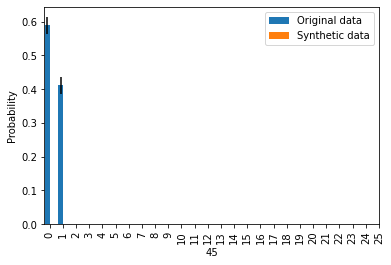

In [ ]:
draw_comparative_hist(rename_key, data_without[nodes_without_loc_net[rename_key]['V']], sample1, {key1: val1 for key1, val1 in nodes_type_without.items() if key1 in nodes_without_loc_net[rename_key]['V']})

In [ ]:
def draw_comparative_hist(parameter: str, original_data: pd.DataFrame,
                          synthetic_data: pd.DataFrame, synthetic_data2: pd.DataFrame,  node_type: dict, rename_again_inv: dict):
    

    if node_type[parameter] == 'disc':
        plt.clf()
        df1 = pd.DataFrame()
        probs = get_probability(sample=original_data, initial_data=original_data,parameter=parameter)

        df1[parameter] = list(probs.keys())

        df1['Probability'] = [p[1] for p in probs.values()]
        df1['Error'] = [p[2] - p[1] for p in probs.values()]
        df1['Data'] = 'Original data'

        df2 = pd.DataFrame()
        probs = get_probability(sample=synthetic_data, initial_data=original_data, parameter=parameter)
        df2[parameter] = list(probs.keys())
        df2['Probability'] = [p[1] for p in probs.values()]
        df2['Error'] = [p[2] - p[1] for p in probs.values()]
        df2['Data'] = 'Clustered'

        df3 = pd.DataFrame()
        probs = get_probability(sample=synthetic_data2, initial_data=original_data, parameter=parameter)
        df3[parameter] = list(probs.keys())
        df3['Probability'] = [p[1] for p in probs.values()]
        df3['Error'] = [p[2] - p[1] for p in probs.values()]
        df3['Data'] = 'Without clustering'

        final_df = pd.concat([df1, df2, df3])

        grouped_barplot(final_df, parameter, 'Data', 'Probability', 'Error')
    # else:
    #     sns.distplot(processor.data[parameter], hist=False, label='Исходные данные')
    #     sns.distplot(data_without_restore[parameter], hist=False, label='Данные из сети с изучаемым узлом')
    #     ax = sns.distplot(data_with_restore[parameter], hist=False, label='Данные из сети без изучаемого узла')
    #     ax.legend()
    
    plt.savefig(f'barplot_{rename_again_inv[parameter]}')
    #plt.show()
    plt.close()

In [ ]:

ind = 1
D_coded = {}
D_without = {}
for key, val in nodes_loc_param.items():
    print(ind / len(nodes_loc_param))
    ind += 1
    try:
        type = "hamm_"
        save_structure(nodes_loc_net[key], f'{type}coded_vars_full_net_{rename_again_inv[key]}')
        skelet = read_structure(f'{type}coded_vars_full_net_{rename_again_inv[key]}')
        params = read_params(f'{type}coded_vars_full_param_{rename_again_inv[key]}')
        bn_h = HyBayesianNetwork(skelet, params)
        sample1 = generate_synthetics(bn_h, get_nodes_sign(data_add[nodes_loc_net[key]['V']]), 'simple', 1500)
        D_coded[key] = su_dist(data_add.sample(n=len(sample1), random_state=1)[key].apply(str).values, sample1[key].apply(str).values)

        save_structure(nodes_without_loc_net[key], f'{type}without_net_{rename_again_inv[key]}')
        skelet2 = read_structure(f'{type}without_net_{rename_again_inv[key]}')
        params2 = read_params(f'{type}without_param_{rename_again_inv[key]}')
        bn_h2 = HyBayesianNetwork(skelet2, params2)
        sample2 = generate_synthetics(bn_h2, get_nodes_sign(data_without[nodes_without_loc_net[key]['V']]), 'simple', 1500)
        D_without[key] = su_dist(data_without.sample(n=len(sample2), random_state=1)[key].apply(str).values, sample2[key].apply(str).values)

        """draw_comparative_hist(key, data_without[[key]],
                          sample1[[key]], sample2[[key]],  {key: 'disc'})"""
    except Exception as e: 
        print(e)

0.037037037037037035
0.07407407407407407
0.1111111111111111
0.14814814814814814
0.18518518518518517
0.2222222222222222
0.25925925925925924
0.2962962962962963
0.3333333333333333
0.37037037037037035
0.4074074074074074
0.4444444444444444
0.48148148148148145
0.5185185185185185
0.5555555555555556
0.5925925925925926
0.6296296296296297
0.6666666666666666
0.7037037037037037
0.7407407407407407
0.7777777777777778
0.8148148148148148
0.8518518518518519
0.8888888888888888
0.9259259259259259
0.9629629629629629
1.0


In [ ]:
D_coded

{'5': 0.0,
 '12': 0.0,
 '42': 0.0,
 '46': 0.0,
 '13': 0.9742516722907234,
 '14': 0.9844418708777944,
 '15': 0.9986390512089455,
 '16': 0.9797456601609331,
 '17': 0.972209949593803,
 '18': 0.9971280598996409,
 '19': 0.9996745099893009,
 '20': 0.9996575375265155,
 '21': 0.996868289211854,
 '22': 0.9826361708275747,
 '23': 0.9891695608048451,
 '24': 0.9934754860913948,
 '27': 0.9961474530457206,
 '32': 0.9985794741052679,
 '34': 0.9976433801429948,
 '35': 0.9999774907150674,
 '29': 0.9967632807126424,
 '31': 0.995691158429375,
 '30': 0.9964854386005094,
 '36': 0.9965183000653358,
 '37': 0.9972060575974508,
 '44': 0.9992899904289146,
 '45': 0.9993910926696095}

In [ ]:
np.mean(list(D_coded.values()))

0.8459848494443042

In [ ]:
D_without

{'5': 0.742459725198503,
 '12': 0.8724778842746979,
 '42': 0.7795684115430102,
 '46': 0.8725346694984597,
 '13': 0.9686141398897973,
 '14': 0.9807576836110018,
 '15': 0.9986343282193183,
 '16': 0.9822976769004361,
 '17': 0.9671248448147288,
 '18': 0.9866281088911598,
 '19': 0.9987456215936081,
 '20': 0.9999461067293324,
 '21': 0.9998835675074782,
 '22': 0.9814714510031488,
 '23': 0.9745213974198357,
 '24': 0.988057231464036,
 '27': 0.12271088221158577,
 '32': 0.002145815531134909,
 '34': 0.06342408157507695,
 '35': 0.9999887038420813,
 '29': 0.00287638185300898,
 '31': 0.03502652996363109,
 '30': 0.03719159910107139,
 '36': 0.6208947662408997,
 '37': 0.0025027395999234203,
 '44': 0.37974515884573556,
 '45': 0.9998439489054217}

In [ ]:
np.mean(list(D_without.values()))

0.6800027206010415

In [ ]:
ind = 1
rmse_coded = {}
rmse_without = {}
for key, val in nodes_loc_param.items():
    print(ind / len(nodes_loc_param))
    ind += 1
    try:
        type = "hamm_"
        save_structure(nodes_loc_net[key], f'{type}coded_vars_full_net_{rename_again_inv[key]}')
        skelet = read_structure(f'{type}coded_vars_full_net_{rename_again_inv[key]}')
        params = read_params(f'{type}coded_vars_full_param_{rename_again_inv[key]}')
        bn_h = HyBayesianNetwork(skelet, params)
        accuracy_dict, rmse_dict, real_param, pred_param, indexes = parall_accuracy(bn_h, data_add[nodes_loc_net[key]['V']].astype(str), [key], 'simple', 4)
        rmse_coded[key] = accuracy_dict

        save_structure(nodes_without_loc_net[key], f'{type}without_net_{rename_again_inv[key]}')
        skelet2 = read_structure(f'{type}without_net_{rename_again_inv[key]}')
        params2 = read_params(f'{type}without_param_{rename_again_inv[key]}')
        bn_h2 = HyBayesianNetwork(skelet2, params2)
        accuracy_dict, rmse_dict, real_param, pred_param, indexes = parall_accuracy(bn_h2, data_without[nodes_without_loc_net[key]['V']].astype(str), [key], 'simple', 4)
        rmse_without[key] = accuracy_dict

        """draw_comparative_hist(key, data_without[[key]],
                          sample1[[key]], sample2[[key]],  {key: 'disc'})"""
    except Exception as e: 
        print(e)

0.037037037037037035
Classification metrics can't handle a mix of multiclass and continuous targets
0.07407407407407407
Classification metrics can't handle a mix of multiclass and continuous targets
0.1111111111111111
Classification metrics can't handle a mix of multiclass and continuous targets
0.14814814814814814
Classification metrics can't handle a mix of multiclass and continuous targets
0.18518518518518517
0.2222222222222222
0.25925925925925924
0.2962962962962963
0.3333333333333333
0.37037037037037035
0.4074074074074074
0.4444444444444444
0.48148148148148145
0.5185185185185185
0.5555555555555556
0.5925925925925926
0.6296296296296297
Classification metrics can't handle a mix of multiclass and continuous targets
0.6666666666666666
Classification metrics can't handle a mix of multiclass and continuous targets
0.7037037037037037
Classification metrics can't handle a mix of multiclass and continuous targets
0.7407407407407407
0.7777777777777778
Classification metrics can't handle a mi

In [ ]:
acc_without = [rmse_without[key][key] for key in rmse_without]
np.mean(acc_without)

0.9157857142857143

In [ ]:
acc_coded = [rmse_coded[key][key] for key in rmse_without if rmse_coded[key][key] <= 0.95]
np.mean(acc_coded)

0.877875

[[Text(0, 0, 'Without'), Text(1, 0, 'Clustered')]]

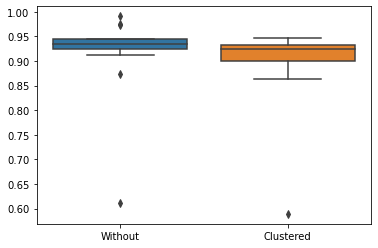

In [ ]:
ax = sns.boxplot(data=[acc_without, acc_coded])
ax.set(xticklabels=['Without', 'Clustered'])

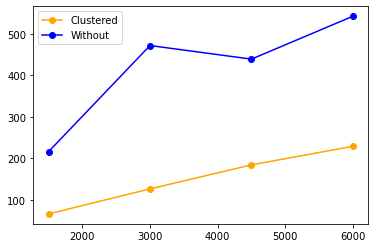

In [ ]:
plt.plot([1500, 3000, 4500, 6000], [65.7, 126.1, 184.1, 228.9], marker='o', color='orange', label='Clustered')
plt.plot([1500, 3000, 4500, 6000], [215.9, 472.1, 439.3, 542.8], marker='o', color='blue', label='Without')
plt.legend()

In [ ]:
for key in bn_dict:
    if key in bn_rename['V']:
        print(key)